# Demonstrating Affine Transformations

## Introduction
This notebook is part of the NRTK demonstration suite, demonstrating how perturbations can be applied and their impact measured via MAITE evaluation workflows.

## Layout
This notebook demonstrates how random affine transformations (translation, rotation and crop), can affect an object detection model, and how that impact can be measured. The overall structure is:

- **Evaluation Guidance: Computing Mean Average Precision (mAP):**
    - An overview of the evaluation strategy.
- **Setup:**
    - Notebook initialization, loading the supporting python code. Depending on if this is the first time you've run this notebook, this may take some time.
    - Loading the source image, which will be used throughout the notebook.
- **Image Perturbation Examples:**
    - The NRTK perturbation is demonstrated on the source image.
- **Baseline Detections:**
    - The object detection model is loaded and run on the unperturbed image. These will serve as \"ground truth\" for comparisons against the perturbed images.
 
At this point, we have the fundamental elements of our evaluation: the model, our reference image, and a mechanism for creating the perturbed test images. Next we adapt these elements to be used with the MAITE evaluation workflow:

- **Wrapping the Detection Model**
- **Wrapping the Reference Image as a Dataset**
- **Wrapping the Perturbation as Augmentation Objects**
- **Wrapping the Metrics**

After the evaluation elements have been wrapped, we can run the evaluation:

- **Preparing the Augmentations:**
    - We specify the range of perturbation values to evaluate and optionally specify which ones we'd like to visualize.
- **Evaluation of Augmented Data:**
    - Each augmentation is run through MAITE's evaluation workflow, computing the absolute mAP metric of the detector on the perturbed datasets.
- **Evaluation Analysis:**
    - We plot and discuss the mAP@50 metric from each of the perturbed images, as well as per-class and per-area results.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/maite/nrtk_affine_perturbers_demo.ipynb)

## Evaluation Guidance: Computing Mean Average Precision (mAP)

This notebook evaluates the robustness of an Object Detector when exposed to NRTK (Natural, Physics-based) perturbations, using mean Average Precision (mAP) as the performance metric. The baseline case, where no perturbations are applied (identity augmentation), typically yields an mAP close to 1.0 and serves as the reference point. Unlike standard evaluations that focus on whether the detector can correctly identify and localize objects, our goal here is to measure how well the detector maintains its performance under realistic perturbations. 

By comparing the absolute mAP scores of the baseline against perturbed datasets, we can assess the detector’s sensitivity to environmental variations and quantify its robustness in generating reliable predictions beyond controlled conditions.

## Setup: Notebook Initialization
The next few cells import the python packages used in the rest of the notebook.

**Note:** We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown.

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

### Setup Environment

In [1]:
from __future__ import annotations

# warning suppression
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

print("Beginning package installation...")
!{sys.executable} -m pip install -qU pip

print("Installing nrtk's extras...")
!{sys.executable} -c "import nrtk" || !{sys.executable} -m pip install -q \
  "nrtk[maite,albumentations]>=0.25.0"

Beginning package installation...
Installing nrtk's extras...


In [3]:
print("Installing required packages...")
!{sys.executable} -m pip install -q "matplotlib"
!{sys.executable} -m pip install -q "torchvision"
!{sys.executable} -m pip install -q "torchmetrics"
!{sys.executable} -m pip install -q "ultralytics"

Installing required packages...


In [4]:
# opencv-python depends on libGL, which is unnecessary for running the notebook
# and can cause failures in some environments (e.g., GitLab CI). To avoid this,
# we uninstall all opencv variants and install opencv-python-headless instead.

# OpenCV must be uninstalled and reinstalled last due to other packages installing OpenCV
print("Doing a fresh install of opencv-python-headless...")
!{sys.executable} -m pip uninstall -qy "opencv-python" "opencv-python-headless"
!{sys.executable} -m pip install -q "opencv-python-headless" --no-cache-dir

Doing a fresh install of opencv-python-headless...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.3.85 requires opencv-python>=4.6.0, which is not installed.
nrtk 0.25.0 requires numpy<2.0,>=1.22; python_version < "3.12", but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
pybsm 0.12.0 requires numpy<2.0,>=1.22; python_version < "3.12", but you have numpy 2.2.6 which is incompatible.
smqtk-classifier 0.19.0 requires numpy<2.0.0,>=1.19.5, but you have numpy 2.2.6 which is incompatible.
ultralytics 8.3.85 requires numpy<=2.1.1,>=1.23.0, but you have numpy 2.2.6 which is incompatible.
xaitk-jatic 0.7.0 requires numpy<2.0,>=1.22; python_version < "3.12", but you have numpy 2.2.6 which is incompatible.
xaitk-saliency 0.13.0 requires numpy<2.0,>=1.25; python_version >= 

### Setup: Imports

In [5]:
import os
import urllib.request
from collections.abc import Iterable, Sequence
from typing import Any

import numpy as np

# some initial imports
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

from matplotlib import pyplot as plt
from PIL import Image

from nrtk.impls.perturb_image.generic.random_crop_perturber import RandomCropPerturber
from nrtk.impls.perturb_image.generic.random_rotation_perturber import RandomRotationPerturber
from nrtk.impls.perturb_image.generic.random_translation_perturber import RandomTranslationPerturber
from nrtk.utils._extras import print_extras_status

print_extras_status()

Detected status of NRTK extras and their dependencies:

[Pillow]
  - Pillow                    ✓ 10.4.0

[albumentations]
  - albumentations            ✓ 2.0.5

[diffusion]
  - torch                     ✓ 2.8.0+cu128
  - diffusers                 ✗ missing
  - accelerate                ✗ missing
  - Pillow                    ✓ 10.4.0

[graphics]
  - opencv-python             ✗ missing

[headless]
  - opencv-python-headless    ✓ 4.12.0

[maite]
  - maite                     ✓ 0.8.2
  - fastapi                   ✓ 0.116.1
  - pydantic                  ✓ 2.10.4
  - pydantic_settings         ✓ 2.7.0
  - uvicorn                   ✓ 0.34.0

[notebook-testing]
  - datasets                  ✓ 4.0.0
  - matplotlib                ✓ 3.9.2
  - numba                     ✗ missing
  - tabulate                  ✓ 0.9.0
  - torch                     ✓ 2.8.0+cu128
  - torchmetrics              ✓ 1.6.2
  - torchvision               ✓ 0.23.0+cu128
  - transformers              ✓ 4.53.1
  - ultralytics   

## Setup: Source Image

In the next cell, we'll download and display a source image from the __[VisDrone](https://github.com/VisDrone/VisDrone-Dataset)__ dataset. The image will be cached in a local `data` subdirectory.

### A Note on Image Storage

Typically in ML workflows, batches of images are processed as tensors of the color channels. Both our perturber (NRTK) and object detector (YOLO) accept numpy `ndarray` objects, and we will use [matplotlib.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) to view them. The complication is that although YOLO inferences on `ndarray`, [it expects the color channels to be in BGR](https://docs.ultralytics.com/modes/predict/) order. If we naively view the same data YOLO inferences on, the colors will be wrong; if we naively inference on what we view, the detections will be wrong. (Our NRTK perturbation is agnostic to the channel order.)

In this notebook, we'll convert the channel order to BGR when we load, and convert back whenever we explicitly call `imshow`.


(540, 960, 3)


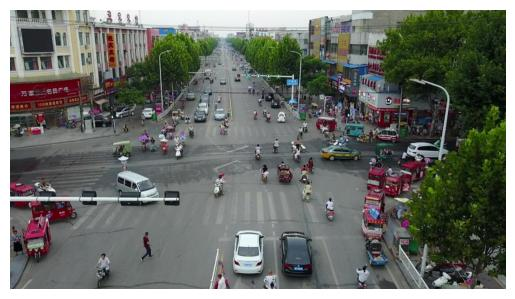

In [6]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_pil = Image.open(img_path)
img_nd_bgr = np.asarray(img_pil)[
    :,
    :,
    ::-1,
]  # tip o' the hat to https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
plt.figure()
plt.axis("off")
print(img_nd_bgr.shape)
_ = plt.imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow

## NRTK Affine transformation perturbations: Examples and Guidance

###  Random Translation Perturbation

The [Random Translation perturbation](<project:../../_implementations/nrtk.impls.perturb_image.generic.random_translation_perturber.rst#module-nrtk.impls.perturb_image.generic.random_translation_perturber>) is by a random sampling from 0 (no translation) to a `max_translation_limit` in both the x and y dimensions. For the purposes of this notebook we will keep the limit the same in both the x and y dimensions

- `max_translation_limit == (0.0, 0.0)` (the minimum value): returns the original image. No pertubation in either direction
- `0.0 < max_translation_limit <= (img_height, img_width)`: Allows translation of between 0 and max_translation_limit in either direction.
- `max_translation_limit > (img_height, img_width)`: Throws an error as it is possible to completely remove the original image via translation
- An arbitratry random `seed = 2` is set for the example below.
  
`max_translation_limit` is a metadata parameter included in the `perturb` call of the augmentation as opposed to an instance level parameter of the `RandomTranslationPerturber` object.

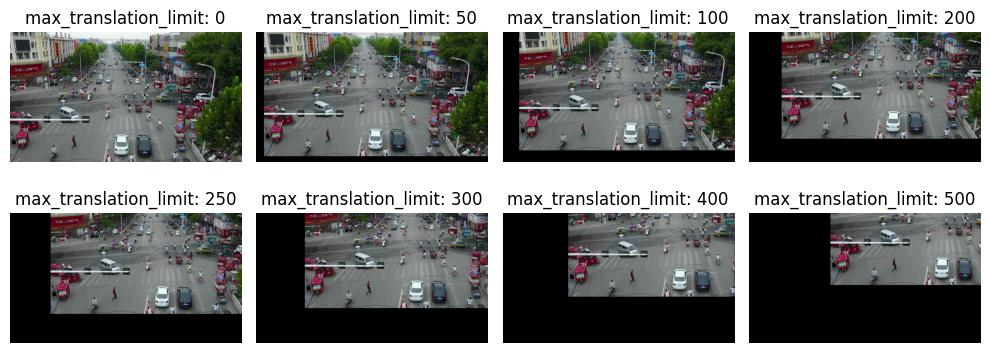

In [7]:
_, ax = plt.subplots(2, 4, figsize=(10, 4))
for idx, limit in enumerate([0, 50, 100, 200, 250, 300, 400, 500]):
    (row, col) = (int(idx / 4), idx % 4)
    translation_perturber = RandomTranslationPerturber(seed=2, color_fill=(0, 0, 0))
    ax[row, col].set_title(f"max_translation_limit: {limit}")
    ax[row, col].imshow(
        translation_perturber(img_nd_bgr, additional_params={"max_translation_limit": (limit, limit)})[0][:, :, ::-1],
    )
    _ = ax[row, col].axis("off")
plt.tight_layout()

###  Random Rotation Perturbation

The [Random Rotation perturbation](<project:../../_implementations/nrtk.impls.perturb_image.generic.random_rotation_perturber.rst#module-nrtk.impls.perturb_image.generic.random_rotation_perturber>) examples shown below are generated by setting a constant set of `limit` values:

- `limit == (0, 0)` is the identity operation which generates the source image.
- We generate rotation-perturbed images in increments of 45 degrees within the range `0 <= limit <= 315`.
- The `probability` is set to `1.0` to ensure that rotation occurs with absolute certainty.
- The `fill` is set to generate a black background.
- An arbitratry random `seed = 3` is set for the example below.

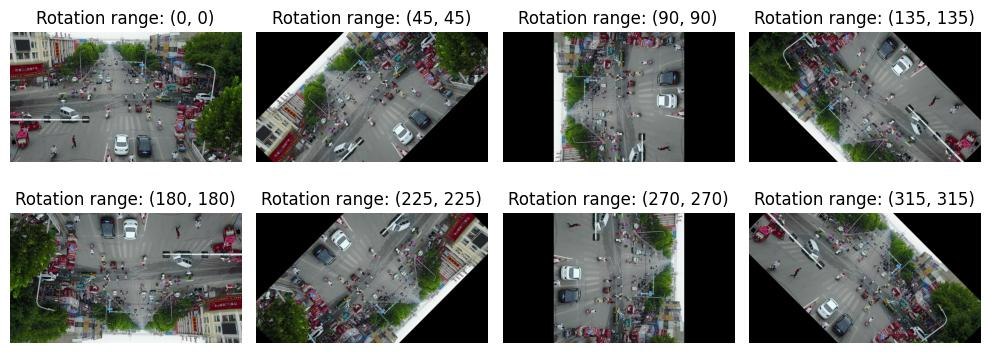

In [8]:
_, ax = plt.subplots(2, 4, figsize=(10, 4))
for idx, limit in enumerate(
    [(0, 0), (45, 45), (90, 90), (135, 135), (180, 180), (225, 225), (270, 270), (315, 315)],
):
    (row, col) = (int(idx / 4), idx % 4)
    rotation_perturber = RandomRotationPerturber(
        limit=limit,
        probability=1.0,
        fill=[0, 0, 0],
        seed=3,
    )
    ax[row, col].set_title(f"Rotation range: {limit}")
    ax[row, col].imshow(rotation_perturber(img_nd_bgr)[0][:, :, ::-1])
    _ = ax[row, col].axis("off")
plt.tight_layout()

###  Random Crop Perturbation

The [Random Crop perturber](<project:../../_implementations/nrtk.impls.perturb_image.generic.random_crop_perturber.rst#module-nrtk.impls.perturb_image.generic.random_crop_perturber>) examples shown below are generated by setting a constant set of `crop_size` values:

- `crop_size == (image_height, image_width)` is the identity operation which generates the source image.
- We generate crop-perturbed images with a set of custom discrete `crop_size` values within the range `img_size / 6 <= crop_size <= img_size`.
- An arbitratry random `seed = 5` is set for the example below.

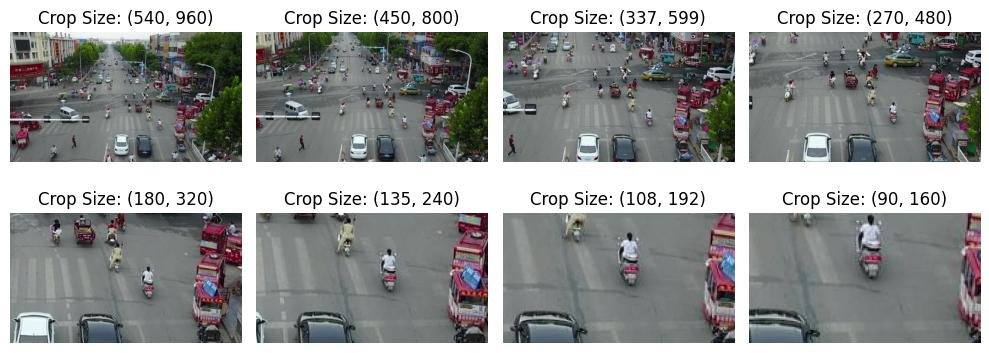

In [9]:
img_h, img_w, _ = img_nd_bgr.shape
_, ax = plt.subplots(2, 4, figsize=(10, 4))
for idx, crop_size in enumerate(
    [
        (img_h, img_w),
        (img_h // 1.2, img_w // 1.2),
        (img_h // 1.6, img_w // 1.6),
        (img_h // 2, img_w // 2),
        (img_h // 3, img_w // 3),
        (img_h // 4, img_w // 4),
        (img_h // 5, img_w // 5),
        (img_h // 6, img_w // 6),
    ],
):
    crop_size = int(crop_size[0]), int(crop_size[1])
    (row, col) = (int(idx / 4), idx % 4)
    crop_perturber = RandomCropPerturber(
        crop_size=crop_size,
        seed=5,
    )
    ax[row, col].set_title(f"Crop Size: {crop_size}")
    ax[row, col].imshow(crop_perturber(img_nd_bgr)[0][:, :, ::-1])
    _ = ax[row, col].axis("off")
plt.tight_layout()

## Baseline Detections

In the next cell, we'll download a [YOLOv11](https://docs.ultralytics.com/models/yolo11/) model, compute object detections on the source image, and display the results. As discussed above, these detections will serve as the "ground truth" for our mAP evaluation later.

*Note that here, we're using YOLO's built-in visualization tool, which automatically adjusts for BGR / RGB order.*

In [10]:
# Import YOLO support
import ultralytics

ultralytics.checks()
print("Downloading model...")
model = ultralytics.YOLO("yolo11n.pt")
print("Computing baseline...")
baseline = model(img_nd_bgr)

Ultralytics 8.3.85 🚀 Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 5000, 15928MiB)
Setup complete ✅ (40 CPUs, 31.0 GB RAM, 396.9/914.7 GB disk)
Computing baseline...

0: 384x640 5 persons, 15 cars, 1 motorcycle, 2 trucks, 60.1ms
Speed: 7.1ms preprocess, 60.1ms inference, 96.0ms postprocess per image at shape (1, 3, 384, 640)


## MAITE Evaluation Workflow Preparation

We'll use the [MAITE Evaluation workflow](https://jatic.pages.jatic.net/cdao/maite/generated/maite.tasks.evaluate.html) to evaluate the performance of the perturbed data against our baseline detections. We'll need to "wrap" our model, data, and perturbations into callable objects to pass to the `maite.tasks.evaluate` function:

- We'll wrap the **model** to make predictions on input data when called.

- The wrapped **dataset** will return our test image when called. Note that this will be the original, unperturbed image; we'll apply our perturbations via...

- ...the **augmentation** object, which applies the perturbation to the image inside the evaluation.

- Finally, the **metric** object will define our precise scoring methodology.

The evaluation workflow in this notebook is slightly unusual. Typical ML workflows apply many different augmentations / perturbations to much larger datasets, and only call `evaluate` once to get a statistical view of performance. But since the goal of this notebook is to drill down into how perturbation affects performance, we've essentially flipped the process, calling `evaluate` (and thus our wrapped objects) many times, once per loop on our single image perturbed to a known degree, and then observing how the metrics respond.

### Some Helper Classes

The following cell adds two classes to allow us to use YOLO detections with the MAITE evaluation workflow:

1. The `YOLODetectionTarget` helper class that stores the bounding boxes, label indices, and confidence scores for a single image's detections.

2. The `MaiteYOLODetection` adapter class that conforms to the MAITE [Object Detection Dataset](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Dataset.html) protocol by providing the `__len__` and `__getitem__` methods. The returned item is a tuple of (image, `YOLODetectionTarget`, metadata-dictionary).

In [11]:
from dataclasses import dataclass

import torch
from maite.protocols.object_detection import DatumMetadataType, ObjectDetectionTarget
from typing_extensions import NotRequired

from nrtk.interop.maite.interop.object_detection.dataset import JATICObjectDetectionDataset

##
## Helper class for containing the boxes, label indices, and confidence scores.
##


@dataclass
class DetectionDatumMetadata(DatumMetadataType):
    """Dataclass for detection datum-level metadata."""

    id: int | str
    max_translation_limit: NotRequired[tuple[int, int]]
    limit: NotRequired[tuple[float, float]]
    crop_size: NotRequired[tuple[int, int]]


@dataclass
class YOLODetectionTarget:
    """A helper class to represent object detection results in the format expected by YOLO-based models.

    Attributes:
        boxes (torch.Tensor): A tensor containing the bounding boxes for detected objects in
            [x_min, y_min, x_max, y_max] format.
        labels (torch.Tensor): A tensor containing the class labels for the detected objects.
            These may be floats for compatibility with specific datasets or tools.
        scores (torch.Tensor): A tensor containing the confidence scores for the detected objects.
    """

    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor


##
## Prepare results for ingestion into maite dataset by puttin them into detection object
## Images must be channel first (c, h, w) in maite dataset objects
##
imgs = [np.transpose(img_nd_bgr, (2, 0, 1))]
dets: list[ObjectDetectionTarget] = []
metadata: list[DetectionDatumMetadata] = [
    {
        "id": 0,
        "max_translation_limit": (0, 0),
        "limit": (0, 0),
        "crop_size": (img_nd_bgr.shape[0], img_nd_bgr.shape[1]),
    },
]
for _detection in baseline:
    boxes = baseline[0].boxes.xyxy.cpu()
    labels = baseline[0].boxes.cls.cpu()  # note, these are floats, not ints
    scores = baseline[0].boxes.conf.cpu()

    dets.append(YOLODetectionTarget(boxes, labels, scores))

### (1) Wrapping the Detection Model

The first object we'll wrap will be the detection model. The cell below defines a class adapting YOLO for the [MAITE Object Detection Model](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Model.html) protocol. The `__call__` method runs the model on images in the batch and is called by the MAITE evaluation workflow later in the notebook.

In [12]:
import maite.protocols.object_detection as od
import ultralytics.models
from maite.protocols import ArrayLike, ModelMetadata


class MaiteYOLODetector:
    """A wrapper class for a YOLO model to simplify its usage with input batches and object detection targets.

    This class takes a YOLO model instance, processes input image batches, and converts predictions into
    `YOLODetectionTarget` instances.

    Attributes:
        _model (ultralytics.models.yolo.model.YOLO): The YOLO model instance used for predictions.

    Methods:
        __call__(batch):
            Processes a batch of images through the YOLO model and returns the predictions as
            `YOLODetectionTarget` instances.
    """

    def __init__(self, model: ultralytics.models.yolo.model.YOLO) -> None:
        """Initializes the MaiteYOLODetector with a YOLO model instance.

        Args:
            model (ultralytics.models.yolo.model.YOLO): The YOLO model to use for predictions.
        """
        self._model = model
        # Dummy model metadata type to pass type checking
        self.metadata = ModelMetadata(id="0")

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[YOLODetectionTarget]:
        """Processes a batch of images using the YOLO model and converts the predictions to `YOLODetectionTarget`s.

        Args:
            batch (Sequence[ArrayLike]): A batch of images in (c, h, w) format (channel-first).

        Returns:
            Sequence[YOLODetectionTarget]: A list of YOLODetectionTarget instances containing the predictions for each
            image in the batch.
        """
        # Convert images to channel-last format (h, w, c) for YOLO model
        batch_transposed = [np.transpose(batch[i], (1, 2, 0)) for i in range(len(batch))]

        yolo_predictions = self._model(batch_transposed, verbose=False)
        return [
            YOLODetectionTarget(
                p.boxes.xyxy.cpu(),  # Bounding boxes in (x_min, y_min, x_max, y_max) format
                p.boxes.cls.cpu(),  # Class indices for the detected objects
                p.boxes.conf.cpu(),  # Confidence scores for the detections
            )
            for p in yolo_predictions
        ]


# create the wrapped model object
yolo_model: od.Model = MaiteYOLODetector(model)

### (2) Wrapping the Dataset

MAITE pairs images and their reference detections (aka targets, ground truth) into **datasets**. Typical ML workflows have many images per dataset; when these do not all fit in memory simultaneously, a *dataloader* object is used which can page images and annotations in from disk. For this notebook, however, each invocation of `evaluate` will use the same single-image dataset (our reference image with its baseline detections.)

In [13]:
# our single image, its baseline detections, and an empty metadata dictionary
# switch image to channel first
single_image_dataset: od.Dataset = JATICObjectDetectionDataset(imgs, dets, metadata, dataset_id="visdrone_ex")

### (3) Wrapping the Perturbations as Augmentations

The `evaluate` function will perturb the image from the dataset using instances of the class defined below, one instance per perturbation value. Note that the object doesn't perform any augmentations until called by the `evaluate` workflow.

In [14]:
from nrtk.interop.maite.interop.object_detection.augmentation import JATICDetectionAugmentation

identity_translation_perturber = RandomTranslationPerturber(seed=2)
identity_translation_augmentation = JATICDetectionAugmentation(identity_translation_perturber, augment_id="identity")

identity_rotation_perturber = RandomRotationPerturber(seed=3)
identity_rotation_augmentation = JATICDetectionAugmentation(identity_rotation_perturber, augment_id="identity")

identity_crop_perturber = RandomCropPerturber(seed=5)
identity_crop_augmentation = JATICDetectionAugmentation(identity_crop_perturber, augment_id="identity")

### (4) Wrapping the Metrics

We'll compare the detections in each perturbed image to the unperturbed detections using the Mean Average Precision (mAP) metric from the `torchmetrics` package. The following cell creates a mAP metrics object, wraps it in a MAITE [MAITE Object Detection Metric](https://jatic.pages.jatic.net/cdao/maite/generated/maite.protocols.object_detection.Metric.html) protocol-compatible class, and then creates an instance of this class, which will be called by `evaluate`.

This code is copied directly from the [MAITE object detection tutorial](https://jatic.pages.jatic.net/cdao/maite/tutorials/torchvision_object_detection.html#metrics) (with the exception of setting `class_metrics=True`.)

In [15]:
from maite.protocols import MetricMetadata
from torchmetrics import Metric as TorchMetric
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##
## Create an instance of the MAP metric object
##

tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro",
)

##
## This wrapper associates the MAP metric object with methods called by the evaluate
## workflow to accumulate detection data and compute the metrics.
##


class WrappedTorchmetricsMetric:
    """A wrapper class for a Torchmetrics metric designed to simplify its usage for object detection tasks.

    This class facilitates the conversion of object detection targets and predictions into the format
    expected by Torchmetrics metrics, allowing for easier integration with existing pipelines.

    Attributes:
        _tm_metric (Callable): The Torchmetrics metric to be wrapped, which takes lists of dictionaries
            containing torch.Tensor objects representing predictions and targets.

    Methods:
        to_tensor_dict(target):
            Converts an `ObjectDetectionTarget` into a dictionary format compatible with the Torchmetrics
            metric's `update` method.

        update(preds, targets):
            Updates the wrapped Torchmetrics metric with batches of predictions and targets in their native format.

        compute():
            Computes the final metric values using the wrapped Torchmetrics metric.

        reset():
            Resets the state of the wrapped Torchmetrics metric.
    """

    def __init__(
        self,
        tm_metric: TorchMetric,
    ) -> None:
        """Initializes the WrappedTorchmetricsMetric with the given Torchmetrics metric.

        Args:
            tm_metric (Callable): A Torchmetrics metric instance that expects predictions and targets as lists of
                dictionaries containing torch.Tensor objects.
        """
        self._tm_metric = tm_metric
        # Dummy metric metadata type to pass type checking
        self.metadata = MetricMetadata(id="0")

    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """Converts an ObjectDetectionTarget into a dictionary format compatible with the Torch's `update` method.

        Args:
            target (od.ObjectDetectionTarget): An object detection target instance containing boxes, labels, and scores.

        Returns:
            dict[str, torch.Tensor]: A dictionary with keys `boxes`, `scores`, and `labels`, each mapping to a tensor.
        """
        return {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels).type(torch.int64),
        }

    def update(self, preds: Sequence[od.TargetType], targets: Sequence[od.TargetType]) -> None:
        """Updates the wrapped Torchmetrics metric with the given predictions and targets.

        Args:
            preds (Sequence[od.TargetType]): A batch of predictions in the format expected by the Torchmetrics metric.
            targets (Sequence[od.TargetType]): A batch of targets in the format expected by the Torchmetrics metric.
        """
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        """Computes and returns the final metric values using the wrapped Torchmetrics metric.

        Returns:
            dict[str, Any]: A dictionary containing the computed metric values.
        """
        return self._tm_metric.compute()

    def reset(self) -> None:
        """Resets the state of the wrapped Torchmetrics metric, clearing any accumulated data."""
        self._tm_metric.reset()


##
## This is our instance variable that can compute the MAP metrics.
##

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)  # noqa: N816

## Running the Evaluation

We now have all the wrappings required to evaluate our range of perturbations:
- The `yolo_model` object, wrapping the YOLO model
- The `single_image_dataset` object, providing our source image and its baseline detections
- The `augmentation` object, which when instantiated, applies a single perturbation value to its input
- The `mAP_metrics` object, defining the metrics to compute at each perturbation value

### Evaluation Sanity Check: Ground Truth Against Itself

Here we quickly check the evaluation workflow by creating an *identity augmentation* and scoring it.  The detections should also be unchanged from the baseline and thus give an mAP of 1.0.

In [16]:
from maite.tasks import evaluate

# call the model for each image in the dataset (in this case, just the source image),
# scoring the resulting detections against those from the dataset

# Random Translation Perturbation
sanity_check_results_translation, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_translation_augmentation,
    metric=mAP_metric,
)

# Random Rotation Perturbation
sanity_check_results_rotation, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_rotation_augmentation,
    metric=mAP_metric,
)

# Random Crop Perturbation
sanity_check_results_crop, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_crop_augmentation,
    metric=mAP_metric,
)

print("Sanity check identity translation: overall mAP (should be 1.0):", sanity_check_results_translation["map"].item())
print("Sanity check identity rotation: overall mAP (should be 1.0):", sanity_check_results_rotation["map"].item())
print("Sanity check identity crop: overall mAP (should be 1.0):", sanity_check_results_crop["map"].item())

100%|██████████| 1/1 [00:00<00:00, 62.98it/s]

Sanity check identity translation: overall mAP (should be 1.0): 1.0
Sanity check identity rotation: overall mAP (should be 1.0): 1.0
Sanity check identity crop: overall mAP (should be 1.0): 1.0


### Preparing the Data

Now we'll prepare the augmentation instances for the evaluation. In the cell below, you can set three parameters for sweeping the set of perturbation values:
- **SWEEP_LOW**: the minimum perturbation value (must be >= 0)
- **SWEEP_HIGH**: the maximum perturbation value
- **SWEEP_COUNT**: how many perturbations to generation

In [17]:
# Create Translation perturbation datasets
SWEEP_LOW = 0.0
SWEEP_HIGH = 100
SWEEP_COUNT = 30

translation_perturbation_values = np.linspace(SWEEP_LOW, SWEEP_HIGH, SWEEP_COUNT, endpoint=True)
translation_augmentation_datasets = []
for idx, p in enumerate(translation_perturbation_values):
    dset_metadata: list[DetectionDatumMetadata] = [{"id": idx, "max_translation_limit": (round(p), round(p))}]
    translation_augmentation_datasets.append(
        JATICObjectDetectionDataset(imgs, dets, dset_metadata, dataset_id=f"augment_{idx}"),
    )

print(f"Generated {len(translation_augmentation_datasets)} translation perturbation datasets")

# Create Rotation perturbation datasets
SWEEP_LOW = 0.0
SWEEP_HIGH = 360
SWEEP_COUNT = 30
VISUALIZATION_INDICES = [3, 9, 21]

rotation_perturbation_values = np.linspace(SWEEP_LOW, SWEEP_HIGH, SWEEP_COUNT, endpoint=True)
rotation_augmentation_datasets = []
for idx, p in enumerate(rotation_perturbation_values):
    dset_metadata: list[DetectionDatumMetadata] = [{"id": idx, "limit": (round(p), round(p))}]
    rotation_augmentation_datasets.append(
        JATICObjectDetectionDataset(imgs, dets, dset_metadata, dataset_id=f"augment_{idx}"),
    )

print(f"Generated {len(rotation_augmentation_datasets)} rotation perturbation datasets")

# Create Crop perturbation datasets
SWEEP_LOW = (img_nd_bgr.shape[0] // 4, img_nd_bgr.shape[1] // 4)
SWEEP_HIGH = (img_nd_bgr.shape[0], img_nd_bgr.shape[1])
SWEEP_COUNT = 30

crop_perturbation_values = np.linspace(SWEEP_HIGH, SWEEP_LOW, SWEEP_COUNT, endpoint=True)
crop_augmentation_datasets = []
for idx, p in enumerate(crop_perturbation_values):
    dset_metadata: list[DetectionDatumMetadata] = [{"id": idx, "crop_size": (round(p[0]), round(p[1]))}]
    crop_augmentation_datasets.append(
        JATICObjectDetectionDataset(imgs, dets, dset_metadata, dataset_id=f"augment_{idx}"),
    )
print(f"Generated {len(crop_augmentation_datasets)} crop perturbation datasets")

Generated 30 translation perturbation datasets
Generated 30 rotation perturbation datasets
Generated 30 crop perturbation datasets


### Calling Evaluate on the Augmented Data

We loop over all the augmentations, calling `evaluate` on each one and building up a list of resulting metrics for analysis.

You can also optionally select perturbations to visualize:
- **VISUALIZATION_INDICES**: a list of perturbation indices *p*, 0 <= *p* < sweep_count. The visualizations for these instances will be rendered along with their corresponding detections.

In [18]:
from ultralytics.engine.model import Model

VISUALIZATION_INDICES = [3, 9, 21]


def _visualize_perturbation(
    idx: int,
    dataset: JATICObjectDetectionDataset,
    model: Model,
    augmentation: JATICDetectionAugmentation,
    metric: od.Metric,
    perturbation_name: str,
    perturbation_value: float | tuple[float, float],
) -> dict[str, Any]:
    """Visualizes the results of perturbations on a dataset."""
    result, _, _ = evaluate(model=yolo_model, dataset=dataset, augmentation=augmentation, metric=metric)

    if idx in VISUALIZATION_INDICES:
        # quickest way is to re-evaluate
        print(f"Perturbation #{idx}: {perturbation_name} perturbation value {perturbation_value}")
        datum = dataset[0]
        batch = ([datum[0]], [datum[1]], [datum[2]])
        # Extract the image from the augmentation and switch it to channel last
        aug = np.transpose(augmentation(batch)[0][0], (1, 2, 0))
        # Plot image
        ax_idx = VISUALIZATION_INDICES.index(idx)
        ax[ax_idx].imshow(model(aug)[0].plot())
        ax[ax_idx].set_title(f"{perturbation_name}: {perturbation_value}")
        _ = ax[ax_idx].axis("off")
    plt.tight_layout()

    return result

#### For Translation perturbed datasets

100%|██████████| 1/1 [00:00<00:00, 42.77it/s]


Perturbation #3: Random translation perturbation value (10, 10)


100%|██████████| 1/1 [00:00<00:00, 46.27it/s]


Perturbation #9: Random translation perturbation value (31, 31)


100%|██████████| 1/1 [00:00<00:00, 48.16it/s]


Perturbation #21: Random translation perturbation value (72, 72)


100%|██████████| 1/1 [00:00<00:00, 47.52it/s]


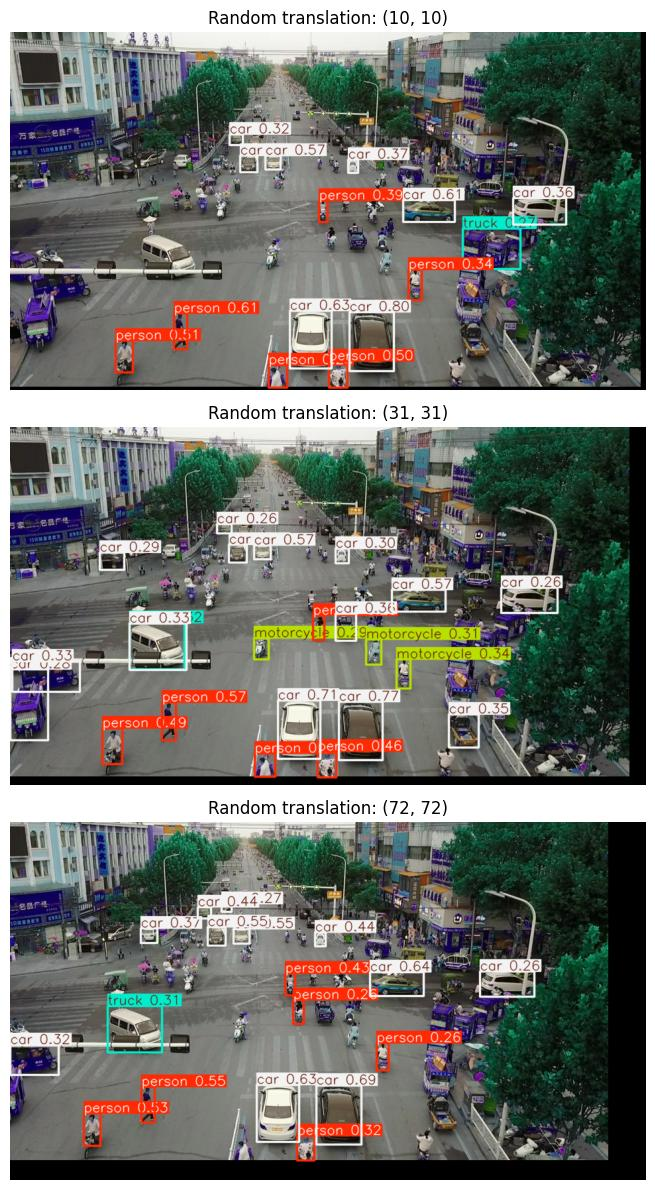

In [19]:
translation_perturbed_metrics = list()
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, dataset in enumerate(translation_augmentation_datasets):
    # reset the metric object for each dataset
    mAP_metric.reset()
    perturber = RandomTranslationPerturber(seed=2)
    augmentation = JATICDetectionAugmentation(perturber, augment_id=str(idx))
    result = _visualize_perturbation(
        idx=idx,
        dataset=dataset,
        model=model,
        augmentation=augmentation,
        metric=mAP_metric,
        perturbation_name="Random translation",
        perturbation_value=dataset[0][-1]["max_translation_limit"],
    )
    translation_perturbed_metrics.append(result)

#### For Rotation perturbed datasets

100%|██████████| 1/1 [00:00<00:00, 44.33it/s]


Perturbation #3: Random rotation perturbation value (37, 37)


100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


Perturbation #9: Random rotation perturbation value (112, 112)


100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


Perturbation #21: Random rotation perturbation value (261, 261)


100%|██████████| 1/1 [00:00<00:00, 61.19it/s]


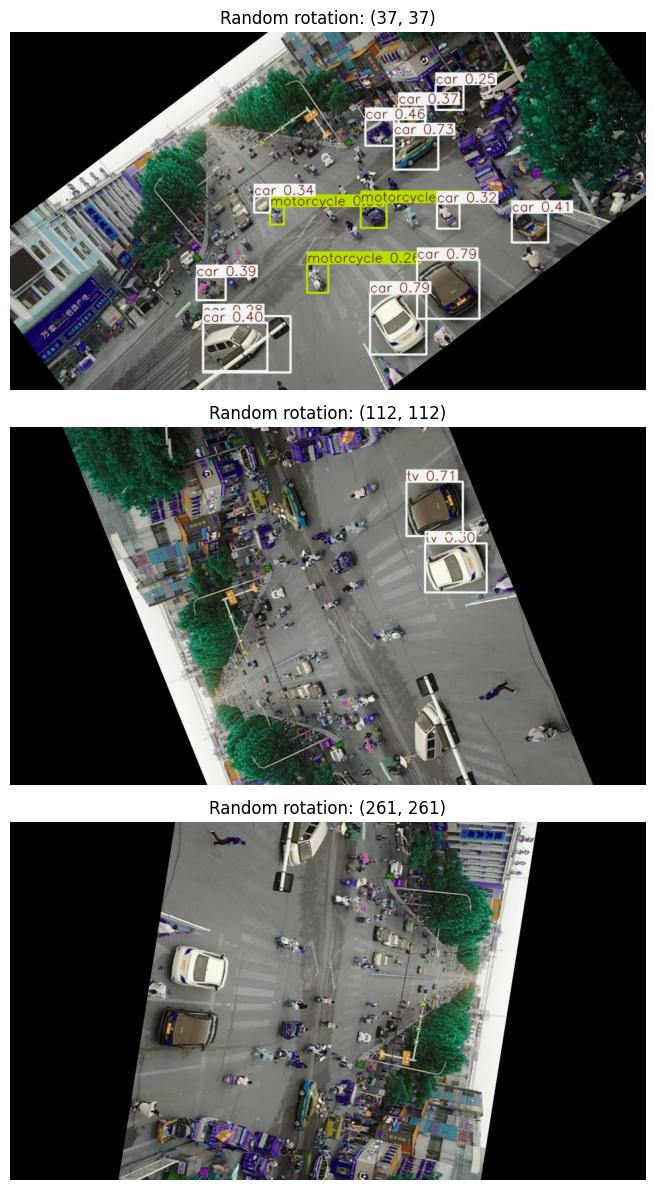

In [20]:
rotation_perturbed_metrics = list()
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, dataset in enumerate(rotation_augmentation_datasets):
    # reset the metric object for each dataset
    mAP_metric.reset()
    perturber = RandomRotationPerturber(seed=3, limit=dataset[0][-1]["limit"])
    augmentation = JATICDetectionAugmentation(perturber, augment_id=str(idx))
    result = _visualize_perturbation(
        idx=idx,
        dataset=dataset,
        model=model,
        augmentation=augmentation,
        metric=mAP_metric,
        perturbation_name="Random rotation",
        perturbation_value=dataset[0][-1]["limit"],
    )
    rotation_perturbed_metrics.append(result)

#### For Crop perturbed datasets

100%|██████████| 1/1 [00:00<00:00, 62.27it/s]


Perturbation #3: Random crop perturbation value (498, 886)


100%|██████████| 1/1 [00:00<00:00, 66.34it/s]


Perturbation #9: Random crop perturbation value (414, 737)


100%|██████████| 1/1 [00:00<00:00, 63.64it/s]


Perturbation #21: Random crop perturbation value (247, 439)


100%|██████████| 1/1 [00:00<00:00, 70.16it/s]


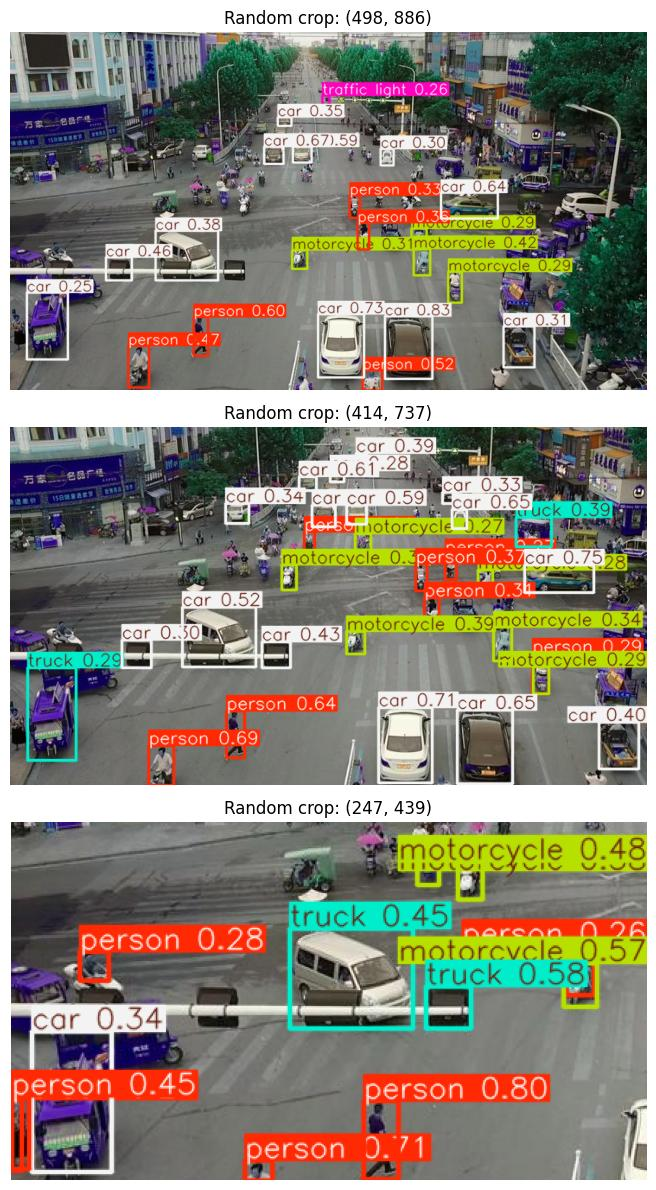

In [21]:
crop_perturbed_metrics = list()
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, dataset in enumerate(crop_augmentation_datasets):
    # reset the metric object for each dataset
    mAP_metric.reset()
    perturber = RandomCropPerturber(seed=5, crop_size=dataset[0][-1]["crop_size"])
    augmentation = JATICDetectionAugmentation(perturber, augment_id=str(idx))
    result = _visualize_perturbation(
        idx=idx,
        dataset=dataset,
        model=model,
        augmentation=augmentation,
        metric=mAP_metric,
        perturbation_name="Random crop",
        perturbation_value=dataset[0][-1]["crop_size"],
    )
    crop_perturbed_metrics.append(result)

## Evaluation Analysis

Now we can plot how the metrics (for example, mAP @ IoU=50) vary with perturbation level, keeping in mind this is the mAP scores compared against the detections in the unperturbed image.


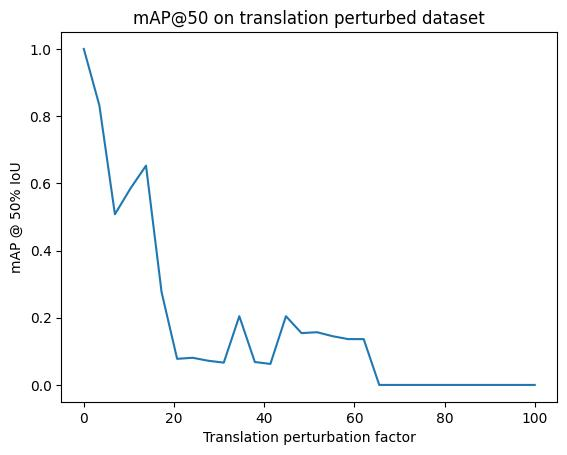

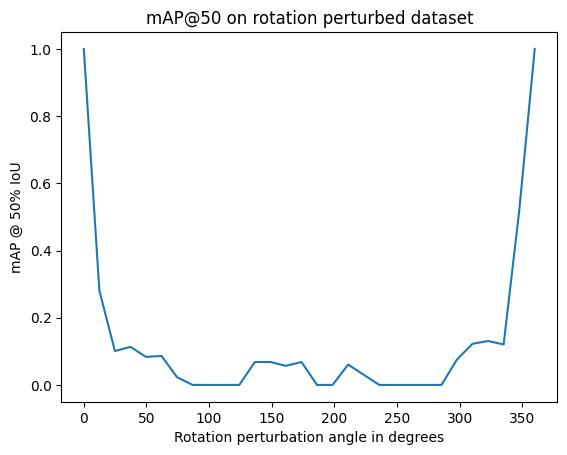

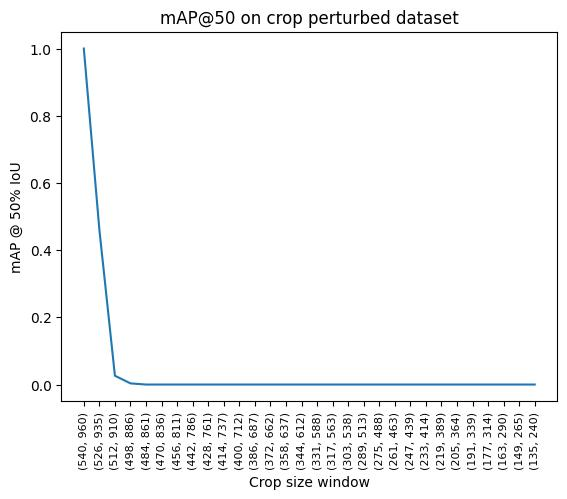

In [22]:
map50_list = [m["map_50"].item() for m in translation_perturbed_metrics]
plt.title("mAP@50 on translation perturbed dataset")
plt.xlabel("Translation perturbation factor")
plt.ylabel("mAP @ 50% IoU")
_ = plt.plot(translation_perturbation_values, map50_list)
plt.show()

map50_list = [m["map_50"].item() for m in rotation_perturbed_metrics]
plt.title("mAP@50 on rotation perturbed dataset")
plt.xlabel("Rotation perturbation angle in degrees")
plt.ylabel("mAP @ 50% IoU")
_ = plt.plot(rotation_perturbation_values, map50_list)
plt.show()

map50_list = [m["map_50"].item() for m in crop_perturbed_metrics]
plt.title("mAP@50 on crop perturbed dataset")
plt.xlabel("Crop size window")
plt.ylabel("mAP @ 50% IoU")
plt.xticks(fontsize=8, rotation=90)
_ = plt.plot([f"({round(p[0])}, {round(p[1])})" for p in crop_perturbation_values], map50_list)
plt.show()

### Evaluation Interpretation

**General things to know about mAP calculation**:
- The mAP metric calculation does not take into account the images that do not have any detection or any ground truth. In such cases, it returns the default initialization value, -1. It means it couldn't compute the metric. (Source: [link](https://github.com/Lightning-AI/torchmetrics/issues/1184#issuecomment-1589210748)). Hence, in this notebook example, we clip values to a range of `[0, 1]`.
- When having images with no ground truth, the order of those images in the batch can change the mAP calculation. To be more precise, if empty images are at the end of the batch, they will be ignored in the computation. But the empty images that are placed before the last non-empty image are taken into account. (Source: [link](https://github.com/Lightning-AI/torchmetrics/issues/1774#issuecomment-1590681234)).


The metric shown, mAP@50, is the average precision of detections across all classes when the bounding box IoU is at least 0.5 (for more details, [see here](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).) After translation is introduced, there is immediately a precipitous drop in performance. 

**Translation perturbation effect**:
After a `max_translation_limit` of around 20, the mAP drops to 0. This is potentially due to the large amount of black space resulting from the newly translated image. (Note the mAP is guaranteed to be 1.0 when the perturbation is 0.0, i.e. when the image is unchanged, the two detection sets are identical.)

**Rotation perturbation effect**:
As soon as we introduce a mere 30 degree rotation `limit`, the mAP drops to `<0.2`. This is potentially due to the fact that model is not robust to rotation-augmented images. As soon as we reach the 360 degree rotation angle (same as 0 degree rotation), the mAP jumps back to a score of `1.0`.

**Crop perturbation effect**:
The introduction of the crop perturbation has proven to drastically drop the mAP scores and reaches `0.0` for a `crop_size` window of `498 x 886` (Note: The original image size is `540 x 960`). The reason for this drop in scores can be attributed to the choice of the crop region made by the perturber. If a crop region with low confidence detections are chosen, that would be a major reason in the drop seen in the `mAP@50` scores.

### Additional Plots

For further insight, we can plot the mAP per class:

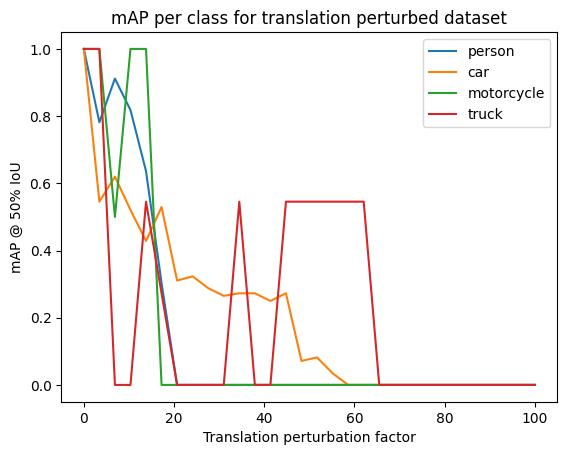

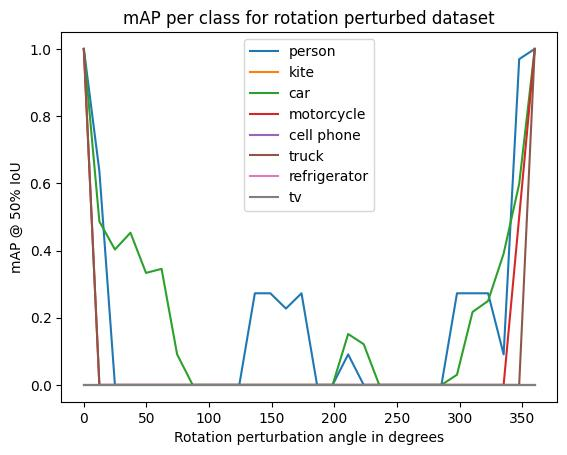

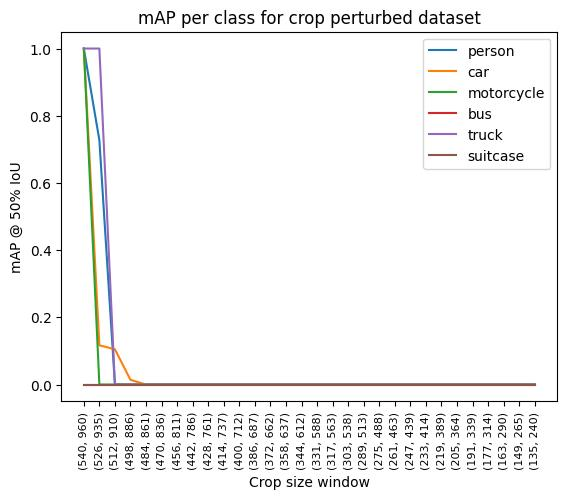

In [23]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#


def _get_classwise_mAP(  # noqa: C901, N802
    perturbed_metrics: Iterable[dict[str, Any]],
) -> dict[str, Any]:
    unified_classes = set()
    for m in perturbed_metrics:
        for class_idx in m["classes"].tolist():
            unified_classes.add(class_idx)

    #
    # dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
    #

    class_mAP = {class_idx: list() for class_idx in unified_classes}  # noqa: N806

    #
    # populate the lists across the perturbation values
    #

    for m in perturbed_metrics:
        this_perturbation_classes = m["classes"].tolist()
        for class_idx in unified_classes:
            if class_idx in this_perturbation_classes:
                # the index of the class in this individual metric instance
                this_class_idx = this_perturbation_classes.index(class_idx)
                class_map_value = m["map_per_class"][this_class_idx].item()
                # Clip value to 0 if negative
                if class_map_value < 0:
                    class_mAP[class_idx].append(0)
                else:
                    class_mAP[class_idx].append(m["map_per_class"][this_class_idx].item())
            else:
                class_mAP[class_idx].append(0)

    return class_mAP


#
# plot
#
plt.title("mAP per class for translation perturbed dataset")
plt.xlabel("Translation perturbation factor")
plt.ylabel("mAP @ 50% IoU")
for class_idx, class_mAP_list in _get_classwise_mAP(translation_perturbed_metrics).items():  # noqa: N816
    plt.plot(translation_perturbation_values, class_mAP_list, label=baseline[0].names[class_idx])
plt.legend()
plt.show()

plt.title("mAP per class for rotation perturbed dataset")
plt.xlabel("Rotation perturbation angle in degrees")
plt.ylabel("mAP @ 50% IoU")
for class_idx, class_mAP_list in _get_classwise_mAP(rotation_perturbed_metrics).items():  # noqa: N816
    plt.plot(rotation_perturbation_values, class_mAP_list, label=baseline[0].names[class_idx])
plt.legend()
plt.show()

plt.title("mAP per class for crop perturbed dataset")
plt.xlabel("Crop size window")
plt.ylabel("mAP @ 50% IoU")
plt.xticks(fontsize=8, rotation=90)
for class_idx, class_mAP_list in _get_classwise_mAP(crop_perturbed_metrics).items():  # noqa: N816
    plt.plot(
        [f"({round(p[0])}, {round(p[1])})" for p in crop_perturbation_values],
        class_mAP_list,
        label=baseline[0].names[class_idx],
    )
plt.legend()
plt.show()

The above plots shows several interesting results:

- Person, car, and truck classes all follow the same general pattern with car being generally the most robust.
- Truck is the most interesting category as it is the only category to have the mAP increase as well as decrease (for the translation perturbation case) and also showing a delayed decrease in mAP (for the crop perturbation case). This is potentially an attribute of the randomization in the perturber, the very few number of truck instances, and the location of the truck instances within the source image.
- In the Rotation and Crop-perturbed dataset cases, we can observe that misdetected classes like TV, refrigerator, etc. are triggered by the perturbations proving that the detector is not quite robust to such perturbations.

Any conclusions about classification accuracy should be considered in light of these caveats. In particular, the foreground positioning of the detected non-car objects suggests that instead of looking at per-class results, we drill down by bounding box area. Fortunately, the metrics class supports this:


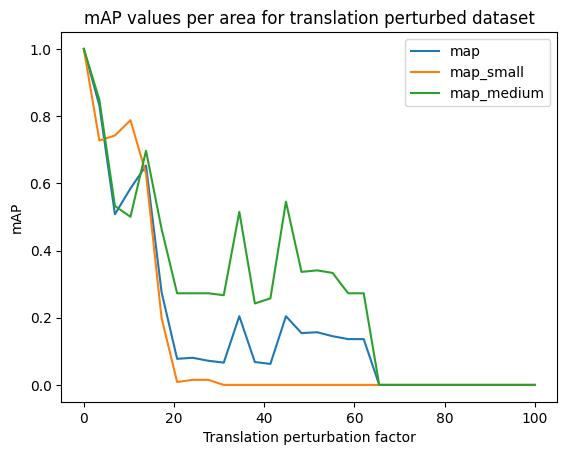

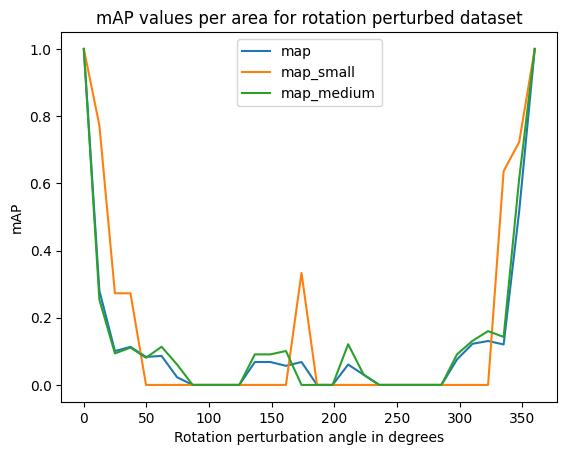

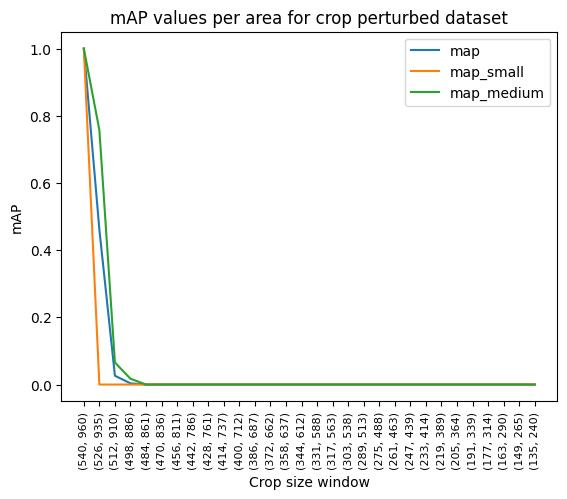

In [24]:
plt.title("mAP values per area for translation perturbed dataset")
plt.xlabel("Translation perturbation factor")
plt.ylabel("mAP")
for k in ("map", "map_small", "map_medium"):
    plt.plot(translation_perturbation_values, [m[k].item() for m in translation_perturbed_metrics], label=k)
plt.legend()
plt.show()

plt.title("mAP values per area for rotation perturbed dataset")
plt.xlabel("Rotation perturbation angle in degrees")
plt.ylabel("mAP")
for k in ("map", "map_small", "map_medium"):
    plt.plot(rotation_perturbation_values, [m[k].item() for m in rotation_perturbed_metrics], label=k)
plt.legend()
plt.show()

plt.title("mAP values per area for crop perturbed dataset")
plt.xlabel("Crop size window")
plt.ylabel("mAP")
plt.xticks(fontsize=8, rotation=90)
for k in ("map", "map_small", "map_medium"):
    plt.plot(
        [f"({round(p[0])}, {round(p[1])})" for p in crop_perturbation_values],
        # Clip values to 0 if negative
        [m[k].item() if m[k].item() >= 0 else 0 for m in crop_perturbed_metrics],
        label=k,
    )
plt.legend()
plt.show()

The `map` line covers all sizes; `map_small` and `map_medium` are the mean average precision for objects (smaller than 32^2 pixels, between 32^2 and 96^2 pixels) in area, respectively. (There are no detections in the `map_large` category.) (Here, the mAP value is averaged over a **range** of IoU thresholds, between 0.5 and 0.95.) We can observe that the medium-sized objects, regardless of class, are generally much more robust to the affine transformation perturbations than small ones. This is most likely due to the smaller objects being more phased out of the image or more rotation-sensitive than medium-sized objects.


## End of Notebook